# QQQ prices prediction

We are going to predict the price of QQQ using the following methods:
1. LSTM
2. Facebook Prophet
3. ARIMA

## Libraries


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from prophet import Prophet
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)

Using device:  cuda


## Data opening and basic functions

In [28]:
def open_data(print_head=False, print_shape=False, keep_date=False):
    df = pd.read_csv('Data\\QQQ_full.csv', header=0, parse_dates=True)
    del df['Unnamed: 0']
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', inplace=True)
    df.set_index('Date', inplace=True)
    df['Volume'] = df['Volume'].str.replace(',', '')
    df['Volume'] = df['Volume'].astype(float)
    df = df.dropna()
    if not keep_date:
        df = df.reset_index(drop=True)
    if print_shape:
        print(df.shape)
    if print_head:
        print(df.head())
    return df

def plot_data(df, columns = ['Close']):
    plt.figure(figsize=(16, 8))
    for i, col in enumerate(columns):
        plt.subplot(len(columns), 1, i+1)
        plt.plot(df[col], label=col)
        plt.title(col, y=0.5, loc='right')
    plt.show()

(1195, 17)
     Open    High     Low   Close      Volume  1-month  3-month  6-month  \
0  150.99  155.75  150.88  154.88  58576672.0     2.40     2.42     2.51   
1  152.60  153.26  149.49  149.82  74820234.0     2.42     2.41     2.47   
2  152.18  157.00  151.74  156.23  74709320.0     2.40     2.42     2.51   
3  156.54  158.86  156.11  158.09  52059328.0     2.42     2.45     2.54   
4  159.56  160.11  157.20  159.52  49388688.0     2.40     2.46     2.54   

   1-year  2-year  3-year  5-year  7-year  10-year  20-year  30-year  \
0    2.60    2.50    2.47    2.49    2.56     2.66     2.83     2.97   
1    2.50    2.39    2.35    2.37    2.44     2.56     2.75     2.92   
2    2.57    2.50    2.47    2.49    2.56     2.67     2.83     2.98   
3    2.58    2.53    2.51    2.53    2.60     2.70     2.86     2.99   
4    2.60    2.58    2.57    2.58    2.63     2.73     2.88     3.00   

   Inflation  
0        2.2  
1        2.2  
2        2.2  
3        2.2  
4        2.2  


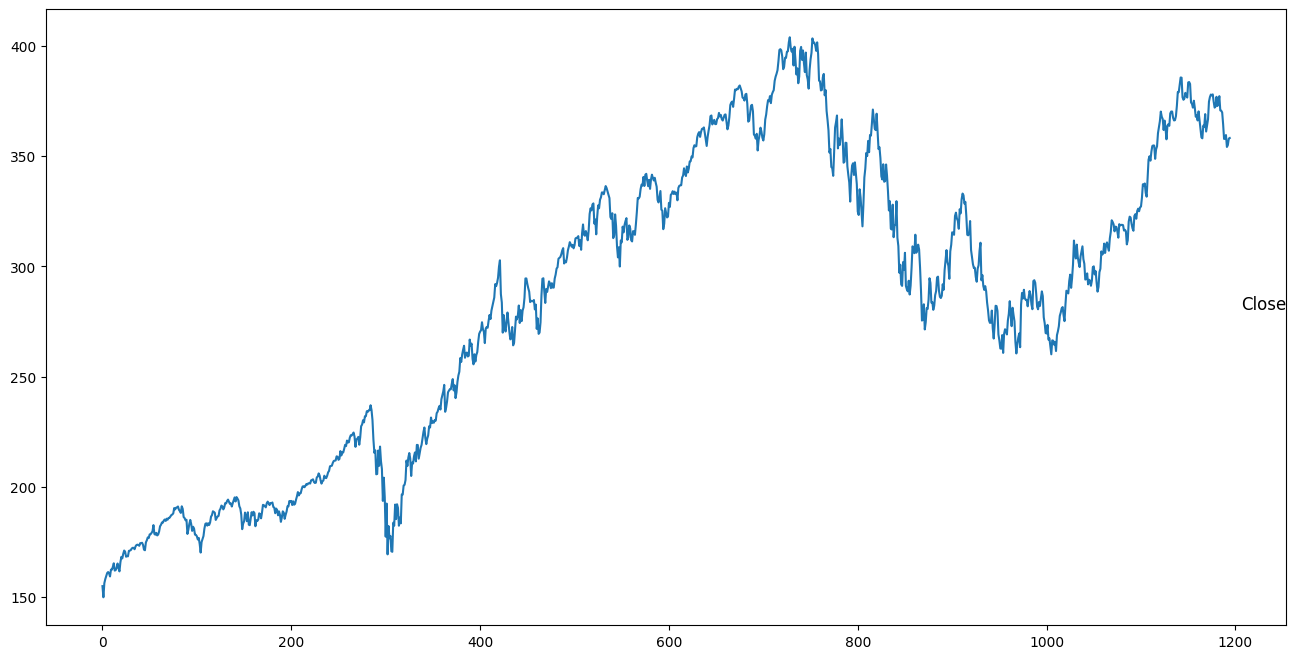

In [29]:
df = open_data(print_head=True, print_shape=True)
plot_data(df)

## Data exploration
We plan to use the predicting closing price of QQQ as the next day's opening price. 
We want to check if there is a huge difference between the closing price and the opening price.

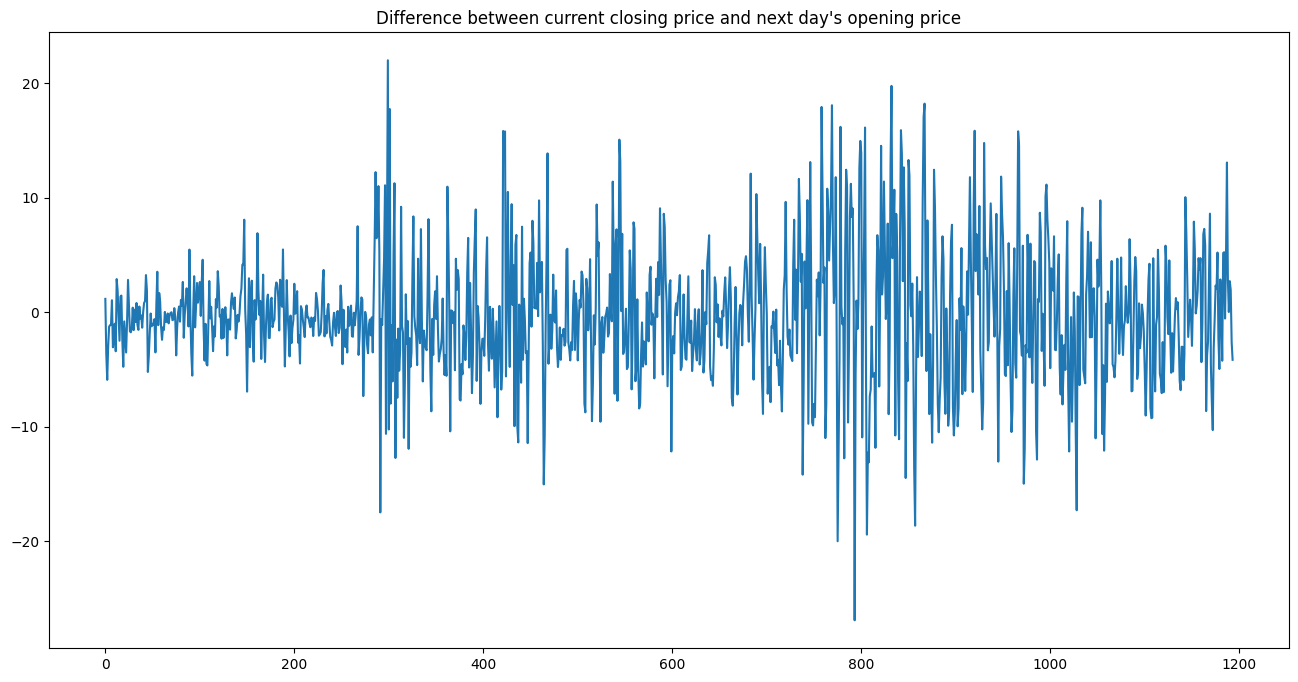

In [30]:
# Plot the difference between the current closing price and next day's opening price

diff = df['Open'] - df['Close'].shift(-1)
plt.figure(figsize=(16, 8))
plt.plot(diff)
plt.title('Difference between current closing price and next day\'s opening price')
plt.show()

As we see from the plot, the difference between the closing price and the opening price is quite huge, and has a high variance. 
Therefore, we are gonna use the it for a day to day strategy, and we will consider that we have access to the current day's opening price.

# Prediction with LSTM

## Data preparation

In [31]:
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
y = df['Close']
X = df.drop('Close', axis=1)

# We are going to predict the next closing price using the previous 60 closing prices
y = y[X.index]

X = X_scaler.fit_transform(X)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

class StockDataset(Dataset):
    def __init__(self, X, y, device=device, window=60):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)
        self.y = self.y.view(-1, 1)
        self.len = len(X) - window
        self.window = window
    
    def __getitem__(self, index):
        start = index
        end = index + self.window
        return self.X[start:end], self.y[end-1]
    
    def __len__(self):
        return self.len
    
train_set = StockDataset(X_train, y_train)
test_set = StockDataset(X_test, y_test)

In [33]:
print("Train set size: ", len(train_set))
# orint the first 5 samples
for i in range(5):
    print(train_set[i])

Train set size:  896
(tensor([[-1.0000e+00, -9.8050e-01, -9.8902e-01, -4.6467e-01, -2.0266e-01,
         -1.3725e-01, -1.0912e-01, -6.0550e-02, -4.1750e-02, -1.0438e-02,
          2.6786e-02,  1.6166e-02,  4.6455e-02, -3.2099e-02,  5.8824e-02,
         -6.2963e-01],
        [-9.8735e-01, -1.0000e+00, -1.0000e+00, -2.9578e-01, -1.9601e-01,
         -1.4082e-01, -1.2343e-01, -9.7248e-02, -8.5487e-02, -6.0543e-02,
         -2.6786e-02, -3.9261e-02, -2.4450e-03, -7.1605e-02,  3.2086e-02,
         -6.2963e-01],
        [-9.9065e-01, -9.7072e-01, -9.8222e-01, -2.9694e-01, -2.0266e-01,
         -1.3725e-01, -1.0912e-01, -7.1560e-02, -4.1750e-02, -1.0438e-02,
          2.6786e-02,  1.6166e-02,  5.1345e-02, -3.2099e-02,  6.4171e-02,
         -6.2963e-01],
        [-9.5640e-01, -9.5616e-01, -9.4769e-01, -5.3243e-01, -1.9601e-01,
         -1.2656e-01, -9.8390e-02, -6.7890e-02, -2.9821e-02,  6.2630e-03,
          4.4643e-02,  3.4642e-02,  6.6015e-02, -1.7284e-02,  6.9519e-02,
         -6.2963e-01]

## Model definition

In [81]:
# Define the LSTM model

class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # add 2 fully-connected layers:
        self.linear = nn.Linear(hidden_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,output_size)
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear2(self.linear(lstm_out.view(len(seq),-1)))
        return pred[-1]
    
# Define a 2nd bigger LSTM model with 2 LSTM layers and 3 fully-connected layers

class LSTMnetwork2(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add 2 LSTM layers:
        self.lstm1 = nn.LSTM(input_size,hidden_size)
        self.lstm2 = nn.LSTM(hidden_size,hidden_size)
        
        # add 3 fully-connected layers:
        self.linear = nn.Linear(hidden_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,hidden_size)
        self.linear3 = nn.Linear(hidden_size,output_size)
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out1, self.hidden = self.lstm1(
            seq.view(len(seq),1,-1), self.hidden)
        lstm_out2, self.hidden = self.lstm2(
            lstm_out1.view(len(seq),1,-1), self.hidden)
        pred = self.linear3(self.linear2(self.linear(lstm_out2.view(len(seq),-1))))
        return pred[-1]
    
# Define a 3rd bigger LSTM model with 2 LSTM layers, 3 fully-connected layers and dropout, RELU activation function and l1 regularization

class LSTMnetwork3(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add 3 LSTM layers:
        self.lstm1 = nn.LSTM(input_size,hidden_size)
        self.lstm2 = nn.LSTM(hidden_size,hidden_size)
        
        # add 3 fully-connected layers:
        self.linear = nn.Linear(hidden_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,hidden_size)
        self.linear3 = nn.Linear(hidden_size,output_size)

        # add dropout layer:
        self.dropout = nn.Dropout(0.2)

        # add RELU activation function:
        self.relu = nn.ReLU()
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out1, self.hidden = self.lstm1(
            seq.view(len(seq),1,-1), self.hidden)
        lstm_out2, self.hidden = self.lstm2(
            lstm_out1.view(len(seq),1,-1), self.hidden)
        pred = self.linear3(self.dropout(self.relu(self.linear2(self.relu(self.linear(lstm_out2.view(len(seq),-1)))))))
        return pred[-1]

## Model training

In [41]:
input_size = len(X_train[0])
model = LSTMnetwork2(input_size=input_size).to(device)
criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

model

LSTMnetwork2(
  (lstm1): LSTM(16, 100)
  (lstm2): LSTM(100, 100)
  (linear): Linear(in_features=100, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=1, bias=True)
)

Epoch 0 Loss: 0.12820012867450714
Test loss: 0.6051719784736633
Epoch 1 Loss: 0.04216192290186882
Test loss: 0.68093341588974
Epoch 2 Loss: 0.10274107754230499
Test loss: 0.7951136827468872
Epoch 3 Loss: 0.0452645979821682
Test loss: 0.6905632615089417
Epoch 4 Loss: 0.0716487318277359
Test loss: 0.6580725908279419
Epoch 5 Loss: 0.011586662381887436
Test loss: 0.6457068920135498
Epoch 6 Loss: 0.012208547443151474
Test loss: 0.6093525886535645
Epoch 7 Loss: 0.01818302646279335
Test loss: 0.6088284850120544
Epoch 8 Loss: 0.06331896781921387
Test loss: 0.7123268246650696
Epoch 9 Loss: 0.003235902637243271
Test loss: 0.7575092911720276
Epoch 10 Loss: 0.012512359768152237
Test loss: 0.7442532181739807
Epoch 11 Loss: 0.023973267525434494
Test loss: 0.7372958064079285
Epoch 12 Loss: 0.028353367000818253
Test loss: 0.7795189619064331
Epoch 13 Loss: 0.033638838678598404
Test loss: 0.7321473360061646
Epoch 14 Loss: 0.038842130452394485
Test loss: 0.6609185338020325
Epoch 15 Loss: 0.00258722528815

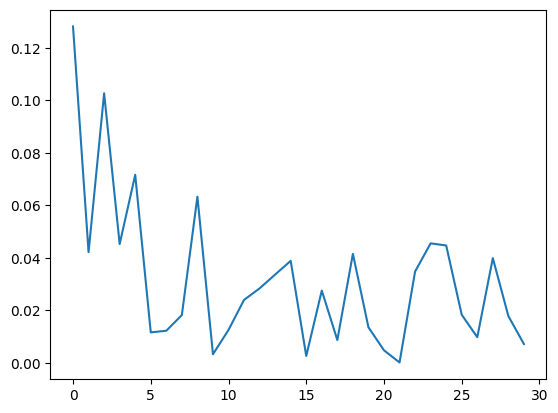

In [42]:
epochs = 30

losses = []

best_model = None
best_loss = 1000000

for i in range(epochs):
    for seq, y_train in train_set:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                        torch.zeros(1, 1, model.hidden_size).to(device))
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f'Epoch {i} Loss: {loss.item()}')

    for seq, y_train in test_set:
        model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                        torch.zeros(1, 1, model.hidden_size).to(device))
        with torch.no_grad():
            y_test_pred = model(seq)
            test_loss = criterion(y_test_pred, y_train)
    print(f'Test loss: {test_loss.item()}')
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = model

plt.plot(range(epochs), losses)
plt.show()

## Model evaluation and saving

We are now going to evaluate the model and save it.
We first want to graphicly see the results of the prediction. We are going to plot the prediction and the real values.

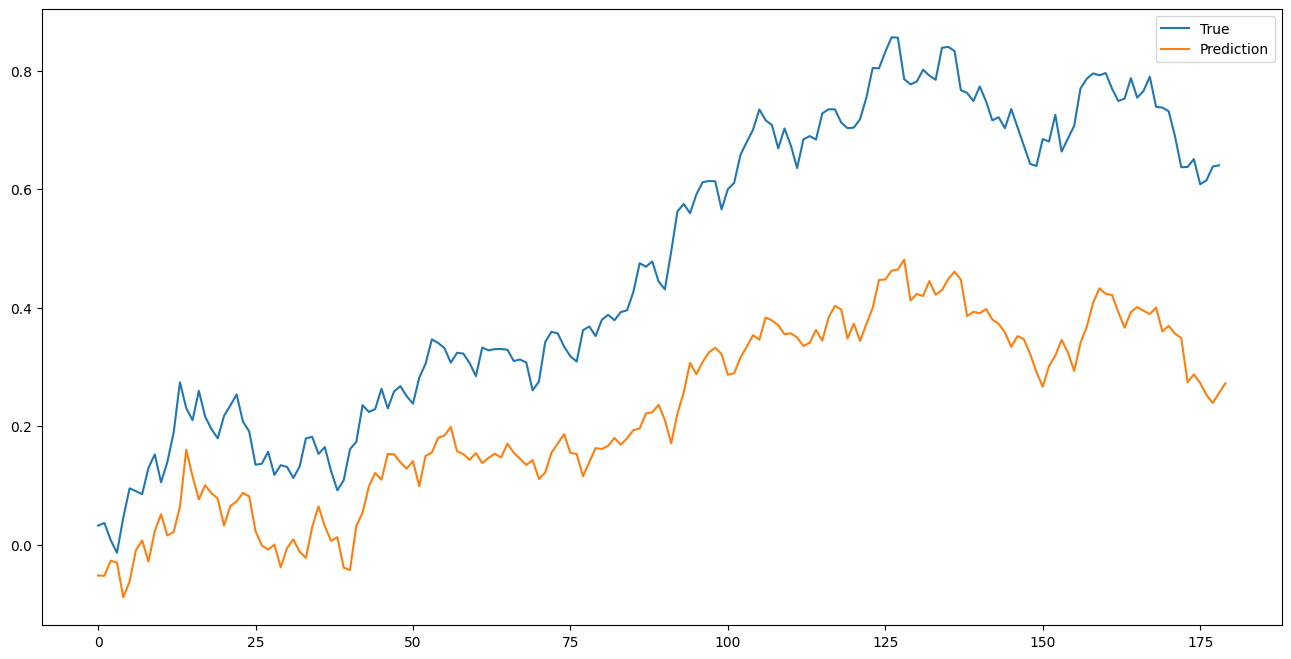

In [43]:
# predict the test set
test_preds = []
for seq, _ in test_set:
    best_model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                    torch.zeros(1, 1, model.hidden_size).to(device))
    with torch.no_grad():
        test_pred = model(seq)
        test_preds.append(test_pred.item())

y_test_array = y_test

# inverse the scaling
#test_preds = y_scaler.inverse_transform(np.array(test_preds).reshape(-1, 1))
#y_test = y_scaler.inverse_transform(y_test)
#test_preds = 60*[0] + list(test_preds.reshape(-1))
# plot the results
plt.figure(figsize=(16, 8))
plt.plot(list(y_test)[60:], label='True')
plt.plot(test_preds, label='Prediction')
plt.legend()
plt.show()

In [32]:
# Save the whole best model
torch.save(best_model, 'best_model_2lstm_2.pt')

## Second model

In [70]:
class ImprovedLSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1, num_layers=2, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Add multiple LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        
        # Add batch normalization after LSTM
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)
        
        # Add multiple fully-connected layers with dropout
        self.linear1 = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout1 = nn.Dropout(p=dropout)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(p=dropout)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, seq):
        lstm_out, _ = self.lstm(seq)

        lstm_out = lstm_out.view(-1, self.hidden_size * 2)
        
        # Apply batch normalization
        lstm_out = self.batch_norm(lstm_out)
        
        # Apply fully-connected layers with dropout
        out = self.dropout1(torch.relu(self.linear1(lstm_out)))
        out = self.dropout2(torch.relu(self.linear2(out)))
        out = self.linear3(out)
        
        return out[-1]

In [77]:
input_size = len(X_train[0])
model = ImprovedLSTMnetwork(input_size=input_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print(model)

ImprovedLSTMnetwork(
  (lstm): LSTM(16, 100, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (batch_norm): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=200, out_features=100, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=100, out_features=1, bias=True)
)


In [78]:
epochs = 30

losses = []

best_model = None
best_loss = 1000000

for i in range(epochs):
    for seq, y_train in train_set:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(2 * model.num_layers, 1, model.hidden_size).to(device),
                        torch.zeros(2 * model.num_layers, 1, model.hidden_size).to(device))
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f'Epoch {i} Loss: {loss.item()}')

    for seq, y_train in test_set:
        model.hidden = (torch.zeros(2 * model.num_layers, 1, model.hidden_size).to(device),
                        torch.zeros(2 * model.num_layers, 1, model.hidden_size).to(device))
        with torch.no_grad():
            y_test_pred = model(seq)
            test_loss = criterion(y_test_pred, y_train)
    print(f'Test loss: {test_loss.item()}')
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = model

Epoch 0 Loss: 0.0015072979731485248
Test loss: 1.0965354442596436
Epoch 1 Loss: 0.00043451430974528193
Test loss: 0.8671467304229736
Epoch 2 Loss: 0.00987919233739376
Test loss: 1.5072156190872192
Epoch 3 Loss: 0.0008535116794519126
Test loss: 0.48907074332237244
Epoch 4 Loss: 0.0053696599788963795
Test loss: 0.5666430592536926
Epoch 5 Loss: 0.009234053082764149
Test loss: 0.5861860513687134
Epoch 6 Loss: 0.0003250172012485564
Test loss: 0.913560152053833
Epoch 7 Loss: 0.0008833854226395488
Test loss: 0.722939670085907
Epoch 8 Loss: 0.003225984051823616
Test loss: 0.7857104539871216
Epoch 9 Loss: 0.003097436623647809
Test loss: 0.46814438700675964
Epoch 10 Loss: 0.00022518591140396893
Test loss: 0.6926823258399963
Epoch 11 Loss: 0.002124339807778597
Test loss: 0.95416659116745
Epoch 12 Loss: 0.0019523814553394914
Test loss: 0.6853757500648499
Epoch 13 Loss: 0.01132251974195242
Test loss: 0.6654269695281982
Epoch 14 Loss: 0.0025784058962017298
Test loss: 0.5177251100540161
Epoch 15 Loss

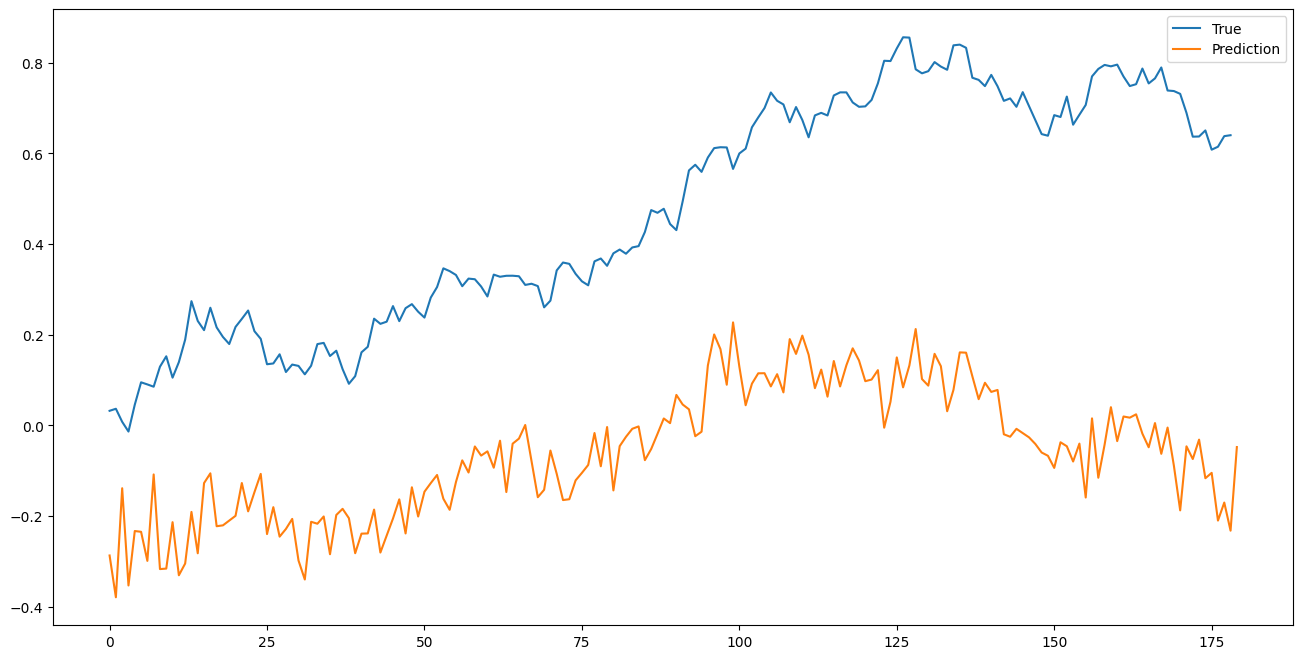

In [79]:
# Now we print the predictions on the test set using the best model
test_preds = []
for seq, _ in test_set:
    best_model.hidden = (torch.zeros(2 * model.num_layers, 1, model.hidden_size).to(device),
                    torch.zeros(2 * model.num_layers, 1, model.hidden_size).to(device))
    with torch.no_grad():
        test_pred = model(seq)
        test_preds.append(test_pred.item())

plt.figure(figsize=(16, 8))
plt.plot(list(y_test)[60:], label='True')
plt.plot(test_preds, label='Prediction')
plt.legend()
plt.show()

# Prediction with Facebook Prophet

## Data opening and preparation

In [16]:
data = open_data(print_head=False, keep_date=True)

# Keep only the date + closing price
data = data[['Close']]
# Transform the date index to a column
data = data.reset_index()

print(data.head())

        Date   Close
0 2019-01-02  154.88
1 2019-01-03  149.82
2 2019-01-04  156.23
3 2019-01-07  158.09
4 2019-01-08  159.52


In [19]:
data.tail()

,ds,y
1190,2023-09-25,359.61
1191,2023-09-26,354.21
1192,2023-09-27,355.04
1193,2023-09-28,358.01
1194,2023-09-29,358.27


In [17]:
# Rename the columns to fit Prophet's requirements
data = data.rename(columns={'Date':'ds', 'Close':'y'})
train_size = int(len(data) * 0.8)
train_df = data[:train_size]
test_df = data[train_size:]

## Grid search for hyperparameters

Here are the hyperparameters we are going to tune:
- changepoint_prior_scale
- seasonality_mode
- growth

In [23]:
# Grid search for the best parameters

from sklearn.model_selection import ParameterGrid

param_grid = {
    'changepoint_prior_scale': [0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'growth': ['linear']
}

grid = ParameterGrid(param_grid)

best_params = None
best_mse = 1000000

for params in grid:
    model = Prophet(**params)
    model.fit(train_df)
    forecast = model.predict(test_df)
    mse = ((forecast['yhat'].values - test_df['y'].values)**2).mean()
    if mse < best_mse:
        best_mse = mse
        best_params = params
    print(params, mse)

11:31:05 - cmdstanpy - INFO - Chain [1] start processing
11:31:05 - cmdstanpy - INFO - Chain [1] done processing
11:31:05 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} 16290.13251022506


11:31:06 - cmdstanpy - INFO - Chain [1] done processing
11:31:06 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} 16272.94684435654


11:31:06 - cmdstanpy - INFO - Chain [1] done processing
11:31:07 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} 16378.075346492724


11:31:07 - cmdstanpy - INFO - Chain [1] done processing
11:31:07 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0} 16038.020913091259


11:31:07 - cmdstanpy - INFO - Chain [1] done processing
11:31:08 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} 15689.442496625785


11:31:08 - cmdstanpy - INFO - Chain [1] done processing
11:31:08 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} 15230.675577941558


11:31:09 - cmdstanpy - INFO - Chain [1] done processing
11:31:09 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} 21556.615329328946


11:31:11 - cmdstanpy - INFO - Chain [1] done processing
11:31:11 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0} 33343.50978757395


11:31:11 - cmdstanpy - INFO - Chain [1] done processing
11:31:12 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} 23268.126578970525


11:31:12 - cmdstanpy - INFO - Chain [1] done processing
11:31:12 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} 24073.368118765564


11:31:13 - cmdstanpy - INFO - Chain [1] done processing
11:31:13 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} 24765.014337531193


11:31:14 - cmdstanpy - INFO - Chain [1] done processing
11:31:14 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0} 24337.324038866453


11:31:14 - cmdstanpy - INFO - Chain [1] done processing
11:31:15 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} 20421.988935463578


11:31:15 - cmdstanpy - INFO - Chain [1] done processing
11:31:15 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} 24642.452163380156


11:31:16 - cmdstanpy - INFO - Chain [1] done processing
11:31:16 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} 69580.66530262337


11:31:17 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0} 68600.99391874412


11:32:17 - cmdstanpy - INFO - Chain [1] start processing
11:32:18 - cmdstanpy - INFO - Chain [1] done processing


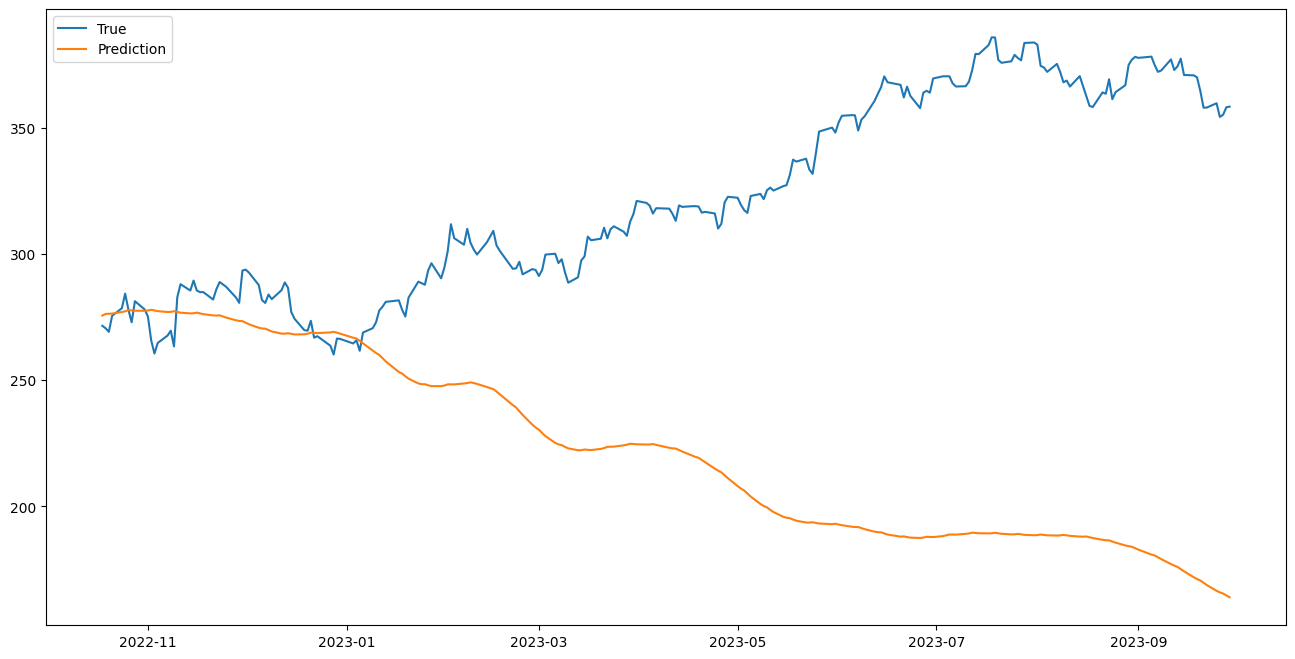

In [25]:
# Train the model with the best parameters
model = Prophet(**best_params)
model.fit(train_df)

# Make predictions
forecast = model.predict(test_df)

# Plot the predictions
plt.figure(figsize=(16, 8))
plt.plot(test_df['ds'], test_df['y'], label='True')
plt.plot(test_df['ds'], forecast['yhat'], label='Prediction')
plt.legend()
plt.show()

Overall, even when trying to perform fine-tuning for the hyperparameters, we are not able to get a good prediction.
Facebook prophet keeps predicting a decrease in the price of QQQ, which is not the case.

# Investment strategy

We are going to use the LSTM model to predict the price of QQQ for the next 10 days.

Using this price, we are going to buy QQQ if the predicted price is higher than the current price, and sell it otherwise. More precisely, each morning we:
- buy QQQ if the predicted price is higher than the current price, and sell it at the end of the day
- short QQQ if the predicted price is lower than the current price, and buy it back at the end of the day

## Model and data opening

In [98]:
predictor = torch.load('best_model_2lstm_2.pt')
predictor.eval()

# Open the data
data = open_data(print_head=True, keep_date=True)

              Open    High     Low   Close      Volume  1-month  3-month  \
Date                                                                       
2019-01-02  150.99  155.75  150.88  154.88  58576672.0     2.40     2.42   
2019-01-03  152.60  153.26  149.49  149.82  74820234.0     2.42     2.41   
2019-01-04  152.18  157.00  151.74  156.23  74709320.0     2.40     2.42   
2019-01-07  156.54  158.86  156.11  158.09  52059328.0     2.42     2.45   
2019-01-08  159.56  160.11  157.20  159.52  49388688.0     2.40     2.46   

            6-month  1-year  2-year  3-year  5-year  7-year  10-year  20-year  \
Date                                                                            
2019-01-02     2.51    2.60    2.50    2.47    2.49    2.56     2.66     2.83   
2019-01-03     2.47    2.50    2.39    2.35    2.37    2.44     2.56     2.75   
2019-01-04     2.51    2.57    2.50    2.47    2.49    2.56     2.67     2.83   
2019-01-07     2.54    2.58    2.53    2.51    2.53    2.60   

In [99]:
# Scale the data
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
y = data['Close']
X = data.drop('Close', axis=1)
y = y[X.index]

X = X_scaler.fit_transform(X)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

We are going to evaluate our strategy over 1 year, from 2022/06/01 to 2023/06/01.

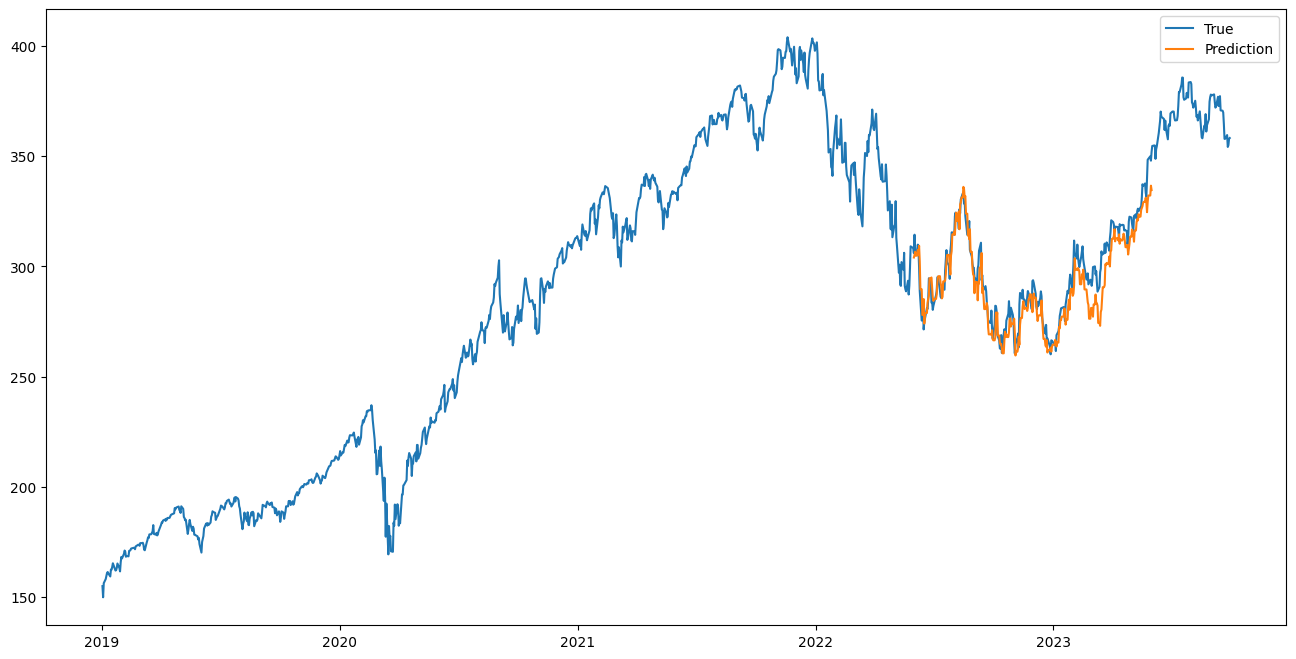

In [100]:
# use the predictor for predicting the closing values

# Create a df with the dates from 2022/06/01 to 2023/06/01
future = pd.DataFrame(pd.date_range(start='2022-06-01', end='2023-06-01'), columns=['date'])
predictions = []
# Make predictions

for date in future['date']:
    # Get the previous 60 days
    start = pd.to_datetime(date) - pd.DateOffset(days=60)
    end = pd.to_datetime(date) - pd.DateOffset(days=1)
    seq = X_scaler.transform(data.loc[start:end].drop('Close', axis=1))
    seq = torch.tensor(seq, dtype=torch.float32).to(device)
    seq = seq.view(len(seq), 1, -1)
    # Make the prediction
    with torch.no_grad():
        pred = predictor(seq).cpu().numpy()
        pred = y_scaler.inverse_transform(pred.reshape(-1, 1))
        predictions.append(pred.item())


# Add the predictions to the df
future['yhat'] = predictions



# Plot the predictions VS the true values
plt.figure(figsize=(16, 8))
data.reset_index(drop=False, inplace=True)
plt.plot(data['Date'], data['Close'], label='True')
plt.plot(future['date'], future['yhat'], label='Prediction')
plt.legend()
plt.show()

In [101]:
print(future.head())
print(data.head())

        date        yhat
0 2022-06-01  304.037476
1 2022-06-02  305.178406
2 2022-06-03  306.643188
3 2022-06-04  304.860016
4 2022-06-05  304.875427
        Date    Open    High     Low   Close      Volume  1-month  3-month  \
0 2019-01-02  150.99  155.75  150.88  154.88  58576672.0     2.40     2.42   
1 2019-01-03  152.60  153.26  149.49  149.82  74820234.0     2.42     2.41   
2 2019-01-04  152.18  157.00  151.74  156.23  74709320.0     2.40     2.42   
3 2019-01-07  156.54  158.86  156.11  158.09  52059328.0     2.42     2.45   
4 2019-01-08  159.56  160.11  157.20  159.52  49388688.0     2.40     2.46   

   6-month  1-year  2-year  3-year  5-year  7-year  10-year  20-year  30-year  \
0     2.51    2.60    2.50    2.47    2.49    2.56     2.66     2.83     2.97   
1     2.47    2.50    2.39    2.35    2.37    2.44     2.56     2.75     2.92   
2     2.51    2.57    2.50    2.47    2.49    2.56     2.67     2.83     2.98   
3     2.54    2.58    2.53    2.51    2.53    2.60     2.

## Strategy evaluation
Now we are going to calculate the profit of our strategy.
We start with 1000 dollars, and we are going to calculate the profit of our strategy over the year, following the rules we defined above.

Profit: -98.3423632588707
ROI: -9.83423632588707%


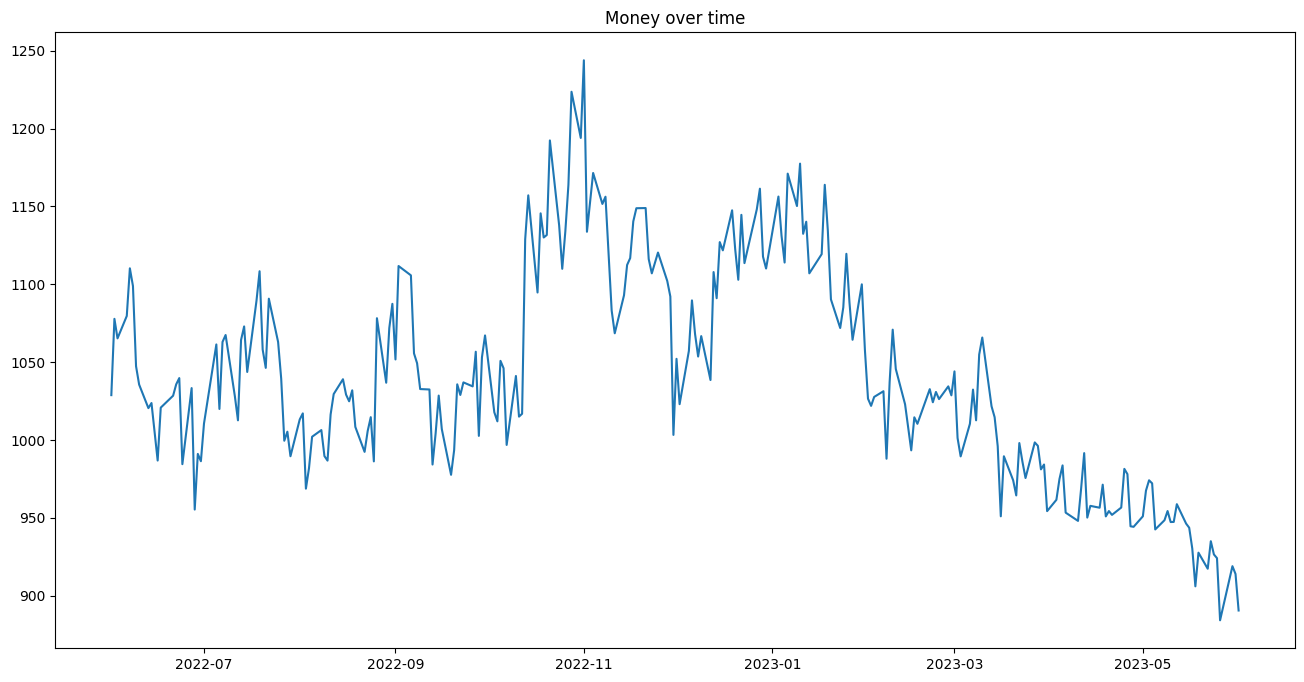

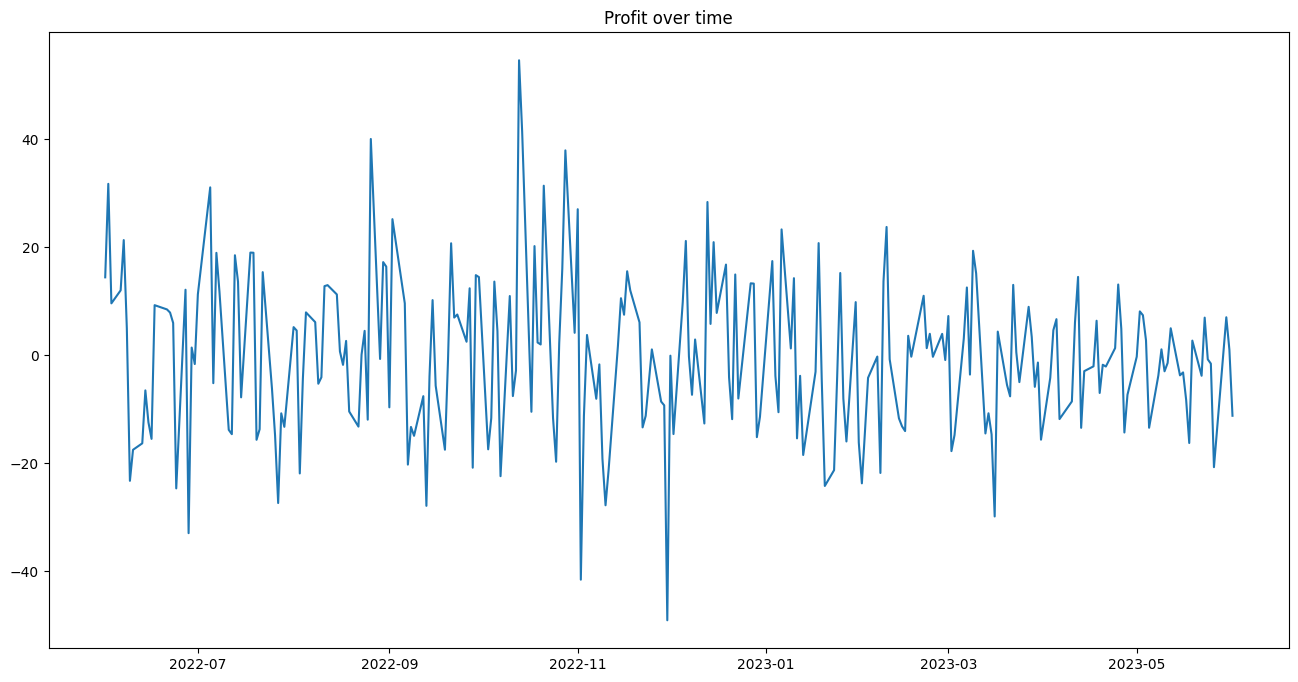

In [112]:
initial_money = 1000.0
# Initialize a "profit" column to store the profit made by the model
future['profit'] = 0.0
future['money'] = initial_money
money = initial_money

# Drop the rows with missing values
future = future.dropna()

# Drop the rows that are not in the data df
future = future[future['date'].isin(data['Date'])]

# Iterate over the rows of the df

for date in future['date']:
    
    open = data.loc[data['Date'] == date]['Open'].values[0]
    close = data.loc[data['Date'] == date]['Close'].values[0]

    predicted_close = future.loc[future['date'] == date]['yhat'].values[0]

    # If the model predicts that the price will go up, buy the stock
    if predicted_close > open:
        nb_shares = money / open
        future.loc[future['date'] == date, 'profit'] = nb_shares * (close - open)
        money = money + nb_shares * (close - open)
        future.loc[future['date'] == date, 'money'] = money + nb_shares * (close - open)

    # If the model predicts that the price will go down, sell the stock
    elif predicted_close < open:
        nb_shares = money / open
        future.loc[future['date'] == date, 'profit'] = nb_shares * (open - close)
        money = money + nb_shares * (open - close)
        future.loc[future['date'] == date, 'money'] = money + nb_shares * (open - close)
    

# print the final profit
print(f'Profit: {money - initial_money}')
# Print the ROI
print(f'ROI: {(money - initial_money) / initial_money * 100}%')

# Plot the daily amount of money
plt.figure(figsize=(16, 8))
plt.plot(future['date'], future['money'])
plt.title('Money over time')
plt.show()

# Plot the daily profit
plt.figure(figsize=(16, 8))
plt.plot(future['date'], future['profit'])
plt.title('Profit over time')
plt.show()
